# Three-Body Problem
by [Paulo Marques](http://pmarques.eu), 2014/03/13

Updated 2016/02/15 for supporting Julia 0.4. Thanks [mbeltagy](https://github.com/mbeltagy) for the contribution.

---

## Introduction
This notebook implements a numeric simulation of the [three-body problem](http://en.wikipedia.org/wiki/Three-body_problem). This is 
done using the [Julia Language](http://julialang.org) and the [Sundials](https://github.com/JuliaLang/Sundials.jl) library. 

The problem corresponds to determine the trajectories of three bodies in space under the influence of their mutual gravity forces (e.g., the motion of the Sun, Moon and Earth, taken together). Isaac Newton was the first person to try to solve this problem. In 1887, Bruns and Poincaré showed that there is no general analytical closed solution for this problem. In fact, the motion of the three bodies is generally non-repeating! That's pretty amazing.

![Planets](http://upload.wikimedia.org/wikipedia/commons/thumb/5/56/1e6m_comparison_Mars_Mercury_Moon_Pluto_Haumea_-_no_transparency.png/600px-1e6m_comparison_Mars_Mercury_Moon_Pluto_Haumea_-_no_transparency.png)

---

## Universal Law of Gravitation

Newton taught us that two bodies with masses $m_0$ and $m_1$ attract themselves with a force proportional to their masses and inversionally proportional to the square of their distance $d$. This is called the [Universal Law of Gravitation](http://en.wikipedia.org/wiki/Newton's_law_of_universal_gravitation). Mathematically this is expressed by: 

$$ F = G \frac{m_0 \, m_1}{d^2} $$

where $G$ is the gravitational constant. But, if we want to consider the movement of three bodies in space, we'll need to formulate this in terms of vector calculus. Let's suppose that mass $m_0$ is at position $\vec{r_0}$ and $m_1$ at position $\vec{r_1}$. This is shown in the next diagram (which also shows a mass $m_2$ and its position -- for now, assume it doesn't exist):

![System](files/imgs/system.png)

In this case, the law of gravitation can be formulated as:

$$ \vec{F_{01}} = - G \frac{m_0 m_1}{{\vert \vec{r_0} - \vec{r_1} \vert}^2} \hat{r_{01}} $$

where $\vec{F_{01}}$ is the force exerted on $m_1$ due to $m_0$ and $\hat{r_{01}}$ is the unit vector from $m_0$ to $m_1$:

$$ \hat{r_{01}} = \frac{\vec{r_1} - \vec{r_0}}{\vert \vec{r_1} - \vec{r_0} \vert} $$

By simple manipulation we can write:

$$ \vec{F_{01}} = - G \, m_0 \, m_1 \frac{\vec{r_1} - \vec{r_0}}{{\vert \vec{r_1} - \vec{r_0} \vert}^3}  $$

Finally, there's an important thing that we also know: force equals mass times accelaration (Newton's second law) and that accelaration is the second derivative of position:

$$ \vec{F} = m \frac{d^2\vec{r}}{dt^2} $$

Thus we can write:

$$ m_1 \frac{d^2\vec{r_1}}{dt^2} = - G \, m_0 \, m_1 \frac{\vec{r_1} - \vec{r_0}}{{\vert \vec{r_1} - \vec{r_0} \vert}^3} $$

If we only had two bodies this would be great. But, with three bodies, we need to consider all the interactions and forces. Since we are calculating the accelaration of $m_1$ we just need to add the force corresponding to $\vec{F_{21}}$:

$$ m_1 \frac{d^2\vec{r_1}}{dt^2} = - G \, m_0 \, m_1 \frac{\vec{r_1} - \vec{r_0}}{{\vert \vec{r_1} - \vec{r_0} \vert}^3} \
                                   - G \, m_2 \, m_1 \frac{\vec{r_1} - \vec{r_2}}{{\vert \vec{r_1} - \vec{r_2} \vert}^3} $$

---
# Equations for Three Bodies

From the last equation above and by symmetry we get the follwing three equations:

$$ \frac{d^2\vec{r_0}}{dt^2} = G \, m_1 \frac{\vec{r_1} - \vec{r_0}}{{\vert \vec{r_1} - \vec{r_0} \vert}^3} + \
                               G \, m_2 \frac{\vec{r_2} - \vec{r_0}}{{\vert \vec{r_2} - \vec{r_0} \vert}^3} $$
                               

$$ \frac{d^2\vec{r_1}}{dt^2} = G \, m_0 \frac{\vec{r_0} - \vec{r_1}}{{\vert \vec{r_0} - \vec{r_1} \vert}^3} + \
                               G \, m_2 \frac{\vec{r_2} - \vec{r_1}}{{\vert \vec{r_2} - \vec{r_1} \vert}^3} $$
                               

$$ \frac{d^2\vec{r_2}}{dt^2} = G \, m_0 \frac{\vec{r_0} - \vec{r_2}}{{\vert \vec{r_0} - \vec{r_2} \vert}^3} + \
                               G \, m_1 \frac{\vec{r_1} - \vec{r_2}}{{\vert \vec{r_1} - \vec{r_2} \vert}^3} $$
                                   
These can be integrated numerically. Let's do so.

---

Let's start by importing a ploting library and a differential equation solver.

In [1]:
using PyPlot
using Sundials

Now we need to define a function $\dot{g} = f(t, g)$ where $g$ is a function of time $t$ and $\dot{g}$ represents its derivative. Using the Sundials library this is done by defining a function ```f(t, g, gdot)```. The function should update the return parameter ```gdot``` with the derivative of ```g(t)``` at time ```t```. Note that this design is not particularly great -- it would be much better if we could just return ```gdot```. (Note that typically $\dot{g} = f(t, g)$ is written as $\dot{y} = f(t, y)$. We are not doing so because we'll be using $x$ and $y$ to denote coordinates.)

Looking at the equations above it's easy to see that both ```y``` and ```ydot``` are going to be 12-entry vectors. We are going to work in two dimentions: X and Y. Thus, each vector $\vec{r_k(t)}$ is going to correspond to two coordinates: $\vec{r_k(t)} = (x_k(t), y_k(t))$. Since we have 3 of these position vectors this corresponds to 6 entries. Since the differencial equations above are of second order, we will need the derivatives of each one of $\vec{r_k(t)}$, which corresponds to the bodies velocities $\vec{v_k(t)}$. Since we have 3 bodies, each with an X and Y velocity, we get 6 other entries.

So, let's write this function using the 3 differential equations above. For simplicity, we'll assume that $G=1$.

In [2]:
function f(t, g, gdot)
    # Extract the position and velocity vectors from the g array
    r0, v0 = g[1:2], g[3:4]
    r1, v1 = g[5:6], g[7:8]
    r2, v2 = g[9:10], g[11:12]
    
    # The derivatives of the position are simply the velocities
    dr0 = v0
    dr1 = v1
    dr2 = v2
    
    # Now calculate the the derivatives of the velocities, which are the accelarations
    # Start by calculating the distance vectors between the bodies (assumes m0, m1 and m2 are global variables)
    # Slightly rewriten the expressions dv0, dv1 and dv2 comprared to the normal equations so we can reuse d0, d1 and d2
    d0  = (r2 - r1) / ( norm(r2 - r1)^3.0 )
    d1  = (r0 - r2) / ( norm(r0 - r2)^3.0 )
    d2  = (r1 - r0) / ( norm(r1 - r0)^3.0 )    
    
    dv0 = m1*d2 - m2*d1
    dv1 = m2*d0 - m0*d2
    dv2 = m0*d1 - m1*d0
    
    # Reconstruct the derivative vector
    gdot[:] = [dr0; dv0; dr1; dv1; dr2; dv2]
end;

For running a simulation we just need to setup the mass of each body, its initial position and velocity. As a sanity check we are also calculating the center of gravity at the end, for each time step, to make sure it's not "drifting" (which would violate the laws of physics).

In [3]:
# Masses of the bodies
m0 = 5.0
m1 = 4.0
m2 = 3.0

# Initial positions and velocities of each body (x0, y0, vx0, vy0) 
gi0 = [ 1.0; -1.0; 0.0; 0.0]
gi1 = [ 1.0;  3.0; 0.0; 0.0]
gi2 = [-2.0; -1.0; 0.0; 0.0]

# Simulation from time t=0 to t=30
tf  = 30.0
dt  = 500
t   = collect(linspace(0.0, tf, round(Int,tf*dt)))
g0  = [gi0; gi1; gi2]
res = Sundials.cvode(f, g0, t, reltol=1e-10)

# Extract the position and velocity vectors from the solution
r0, v0, r1, v1, r2, v2 = res[:,1:2], res[:,3:4], res[:,5:6], res[:,7:8], res[:,9:10], res[:,11:12]

# Calculate the center of mass
cx = [(r0[i,1]*m0 + r1[i,1]*m1 + r2[i,1]*m2) / (m0 + m1 + m2) for i=1:length(t)]
cy = [(r0[i,2]*m0 + r1[i,2]*m1 + r2[i,2]*m2) / (m0 + m1 + m2) for i=1:length(t)]

# Write the results to file if we want to do something with them later on (e.g., create some videos)
# writecsv("results.csv", res);

Now we need a function that allows us to plot the trajectory over time. We'll call it ```plot_trajectory``` and will pass as parameter the start time and stop time to plot.

In [4]:
function plot_trajectory(t1, t2)
    t1i = round(Int,(length(t)-1) * t1/tf) + 1
    t2i = round(Int,(length(t)-1) * t2/tf) + 1
    
    # Plot the initial and final positions
    # In these vectors, the first coordinate will be X and the second Y
    X = 1
    Y = 2
    
    figure(figsize=(6,6))
    plot(r0[t1i,X], r0[t1i,Y], "ro")
    plot(r0[t2i,X], r0[t2i,Y], "rs")
    plot(r1[t1i,X], r1[t1i,Y], "go")
    plot(r1[t2i,X], r1[t2i,Y], "gs")
    plot(r2[t1i,X], r2[t1i,Y], "bo")
    plot(r2[t2i,X], r2[t2i,Y], "bs")
    
    # Plot the trajectories
    plot(r0[t1i:t2i,X], r0[t1i:t2i,Y], "r-")
    plot(r1[t1i:t2i,X], r1[t1i:t2i,Y], "g-")
    plot(r2[t1i:t2i,X], r2[t1i:t2i,Y], "b-")
    
    # Plot cente of mass
    plot(cx[t1i:t2i], cy[t1i:t2i], "kx")
    
    # Setup the axis and titles
    xmin = minimum([r0[t1i:t2i,X]; r1[t1i:t2i,X]; r2[t1i:t2i,X]]) * 1.10
    xmax = maximum([r0[t1i:t2i,X]; r1[t1i:t2i,X]; r2[t1i:t2i,X]]) * 1.10
    ymin = minimum([r0[t1i:t2i,Y]; r1[t1i:t2i,Y]; r2[t1i:t2i,Y]]) * 1.10
    ymax = maximum([r0[t1i:t2i,Y]; r1[t1i:t2i,Y]; r2[t1i:t2i,Y]]) * 1.10
    
    axis([xmin, xmax, ymin, ymax])
    title(@sprintf "3-body simulation for t=[%.1f .. %.1f]" t1 t2)
end;

Let's plot the trajectory from 0 to 10 time units.

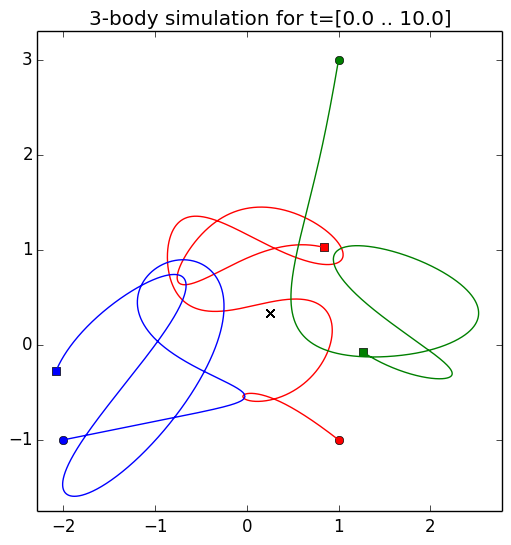

In [5]:
plot_trajectory(0, 10);

That's pretty crazy! The trajectory of each body is drawn in a different color. The start position is marked by a small circle and the end position by a square. The center of gravity is marked with a black X. As you can see the behavior is pretty insane. "Almost collisions" and unstable aperiodic trajectories.

And it goes on and on...

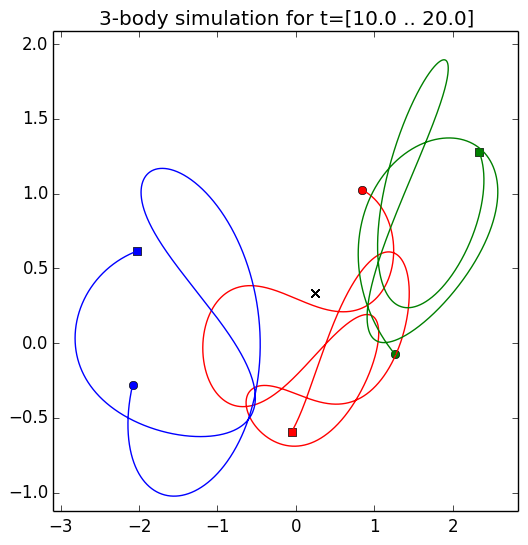

In [6]:
plot_trajectory(10, 20);

It almost looks like they are dancing...

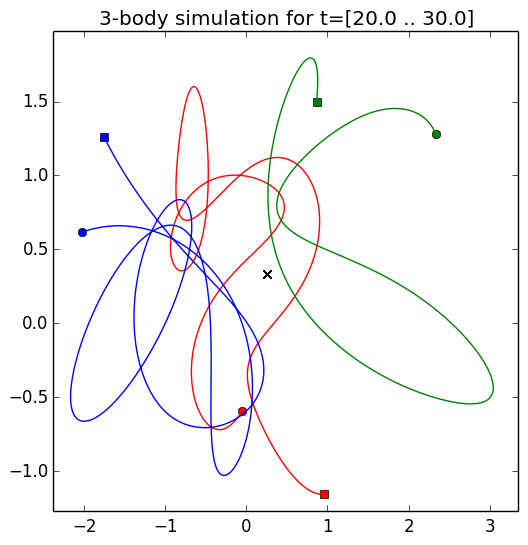

In [7]:
plot_trajectory(20, 30);

---
## Videos 
I've also decided to make three small videos containing the simulation.
[The videos weren't generated here because (i)Julia's support for doing this is not great...] 

Look at all the close encounters!

In [3]:
# Function for creating an embedded video given a filename
function html_video(filename)
    base64_video = base64encode(open(readbytes, filename))
    """<video controls src="data:video/x-m4v;base64,$base64_video">"""
end

videos = [html_video(v) for v=[
    "imgs/3d_body_0_30_small.mp4";
    "imgs/3d_body_0_10_small.mp4";
    "imgs/3d_body_10_20_small.mp4";
    "imgs/3d_body_20_30_small.mp4"]]

table = """
    <table>
        <tr>  <td>$(videos[1])</td>  <td>$(videos[2])</td>  </tr>
        <tr>  <td>$(videos[3])</td>  <td>$(videos[4])</td>  </tr>
    </table>"""

display("text/html", table)

<video controls src="data:video/x-m4v;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQABPCZtZGF0AAACoAYF//+c3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDEyNSAtIEguMjY0L01QRUctNCBBVkMgY29kZWMgLSBDb3B5bGVmdCAyMDAzLTIwMTIgLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwgLSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMgbWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5nZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEgZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz02IGxvb2thaGVhZF90aHJlYWRzPTEgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBiX3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29wPTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0yNSBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0wLjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAACPRliIQAZ/0koAQ8PApsdyd9N11r8UjghYxpS+IAAAMABZogof830zG8Q1BnGkmYyeloJO32qtig+nUDjyNov/xfbF8rKJSqFKriT7XaEorHwHq4f5AbmIqgXJMjlWTDmZx5FrDrHSO8LgCB8T0YFpKFh0VfOs7hUSxf/59eBtWfkVBuexl+/uvgxQtzKpl+hd3vYdmXWI9kqis/HQCMxazSnUKSM7pqAA0OKppDNVaRnEl6QSh88U2PBMVFvZATOEKUroh5ihHsYBw3Ao8F5QoemWW3TmkVM5rUzr9RAEi2CcqOVYezgAYXChlquB9gbx5oI+UTh42HYj+/CmKhc1Ahv4NsVQRiEcYLWGKuIWtWIe2zOJeo7xaHxLvb/DSXpxuvCH81VX3KTjRcDvhtvmz6rQlwE0YeiyvwnCYnLQu98+Fr++AskfyzsCIQ+Wl9o4PZCizGTiR4RwPvV9pZHxUM/EMfUM1hzG9byK2OoyL791ELA24UoAACiVIq9zpsjsMLoNkS8sJwHWYi6ZGz+D6RE4GBH2vffUP/2sv27rIUWWQF9i/yBLmGLSoSMW4dTlvNDjLwgQAqgr6tb4dZ98V4Rtfx+Durwopiwgb66hw3wEWj4uTCFjGc3M9BxAGy1qVhN5K/lOocbwxE3ahLGBYtHhX7WaoxvLbx/noXKDp97sKKIaDS9isZ1FWVNb83EmKme6XNrhXPlTSnHd1Vg1nUs72ZFzZd1qHugdmEyo4RT3SLvV5z1+uyp7ZU5jfrTR4xKrMPKA5EVp2dbowH9IGv8cV/PjaNL6FIOjvPeOSq1Rae1XhNtJbhNjt9kAZmRWt1fAXciGJADfOIEbBhcdHk5LLHUxr3ec80axdMtKOVvBBPS9H0KhopnqOQiEsnMdpi6Ygv49h0wGvVH2CnMQZAUCUwdF1hcarSA6BM8Md9odBUwbdkAAD3C0wz9OP+E4L+sDPRIX48yWUBElaCZJL0/NuHVMG2C51JBjvsOjhjGNe9SBlGMAddYrLIL5NiONjdAyOnHbxcPvYEsq14MtPzaNuFiCt2UEWgxV/9jWf3Lsgn4BU7VjoJcnCjdYupEmPoTvfzt901873Q7N51KBEnIVwPX3yJQXQtPBW7sxGGHvH320wS64AYulwrg3WyPa/7i9LRHDyPLkAnCyzwUOongfqLVsdtmNTNGL9A5GQPXscp0UBOdjMRscuz18yTc4B12nSdt+YeVe+heEZ/XxVDn/afD5F8RnJ4IQaBfT7xmuH6i/I+qXd5mY4SFzoO/4063c7oSkORgQrlV7kM0AAApgyvL2SnzOx413deuRkv1zDAYEWpcJPjJJUN3kzb7aRC3HiqNjNFK1ng9IwYZ7/YX+Y/7eG6Z79qt9+eaw3H31KxK+Utb/d5a7ENqoxqg9lIouDvZa0HiAV3oqvHaapbZuqPBGJ9h87Rz5vXEL1rMxwv76gj7gLSx7kZ4vgj7eOAht6fQAAA3sOGFCUXBAqO2xjnLf/6/mHc8yoDFX1CYAUflytdmhFQGBhC6X7a5SL0z19xqnFhHZ/phA/6LOApJCDWnTZ467LF2vEV6QRjT8bFGwTWWmz6RhceFQBRegoWNhpo6E3WtnIJnnjAnk+49IwGy9ELw+z+/up+mfCmVNHtXyBMnTsLdbIf69df/fo/UNshrayeC3YHK6rVslS/ygrRp01u9rlTpd2LcN1BUjHDkrwLIHCRdTEh+ENHiC8SmD6DoWOmRa/G3nAld7YBJXCW8qB1OsZ47qA3fyS8TIFYeItZxswnE/cl932cD6AYKIYilreBVdkDNYGDshUeCelOb6rvzP2DQ2gzkzHEfPVJvmiOrMJMPK+rZvM/Xvgbjrix/2DebSrzkd5wxX0dWenkEjhip4PAPbT9t8gEKSTAOJH+bZ5SRzgz3HzCQIOXVlwSCm1Y6prnKwqNf+pr2LJ19f70QRgHvtFkWa5HuhDZ8Ub2SrUnK3In29zDusk9ZxHbyuLarGWtNftqRYPUV56OtGFkZBIUew1wvJ8QuaHFKfUVzPv3xD4tTyB/SfYYKifDjb4VHw+qO+OE2XbsZ7VeL2syN5gvtxBx0X61cjCM4TkQEQC3KKt7olXIS9AZ+vYamn86QpguiatMoMLPIy7pWwyPROpzneY8Lc/UNvRIVYe/S7i2N19esAVq4JpdG/ioY36ZUQHdMNZ+vo+MP67QSo42XRX/RGdkfjOgoMQh3i1CsKL6Il1LhzMsQj812ktrvMONjukyEvMsm1xHZ7U7r/czbr+3IzpVb1Rb8ur/+L8gA++fLd4jFOQM/UHgmi72An5gUO7dXgT6Zbo7u8+88SyQlhpoHTtu+uTApwJkEeC60JrBLI+iH/WbXCS6P0w19T3T2xr9bki+bz0OgysSJiGUmj6nucxkiUSSeEuT2+YTHLzvqR0FGB4wPjv/2kjb+E4rFPYOo+0BoHqBqohlI+fft66zC7F7jUsJbv8/9Gscq/dwJHHCkKlSK/rI7LaxQVoCdsQfyuTlgzP+/AI973COekRUFVVXcrikhkhqNEG1j8D+8SyyoP69vX9eaXhNrZMw4NrQykgUsyKOK8BkmvAnY4UrHn6RQpsNhv8ZfonT66f+DbYZH7caAU6Pou30WPOJjrMYDMY/besjhWchVHtLao8PakDQ+F+JsXmAIP7o/k5KKgkwEFyX/CiDG6F4YeDka7iUUYUK3uGa0POz+YmhPHu683D4+u6jOkJN9drDdM5KpUbdXh8LL/q1aGlcmtd5dUsNBxrXxm3m1WVutcvjM6QWyc3Q973hFhMVNxB88BPOom1f34G/qa3m6U1AVyvl3K+Es8KwfeZFCsJmHkf8N+aYAIJlL2D9qbnWihHgdxAFUYfLBJHHFrfNpv/qHxY5gsO6Mzubp/qRNTLyTFmeqbiONu8/0+gIL+5GEUY2O4z9y+M+mws5Nkwo6GgWvOMwqTra+032a0fz8b0wAIdRraO/eqUkKUB

---

# MIT LICENSE

> Copyright (C) 2014 Paulo Marques (pjp.marques@gmail.com)
>
> Permission is hereby granted, free of charge, to any person obtaining a copy of 
> this software and associated documentation files (the "Software"), to deal in
> the Software without restriction, including without limitation the rights to
> use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
> the Software, and to permit persons to whom the Software is furnished to do so,
> subject to the following conditions:
>  
> The above copyright notice and this permission notice shall be included in all 
> copies or substantial portions of the Software.
> 
> THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
> IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
> FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
> COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
> IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN 
> CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.